In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)


### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)


### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1]) 

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                             index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
        Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
        Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


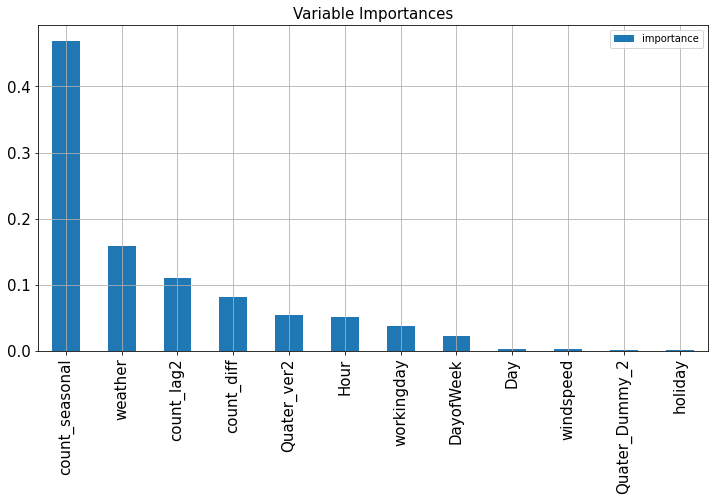

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.92",40.49


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

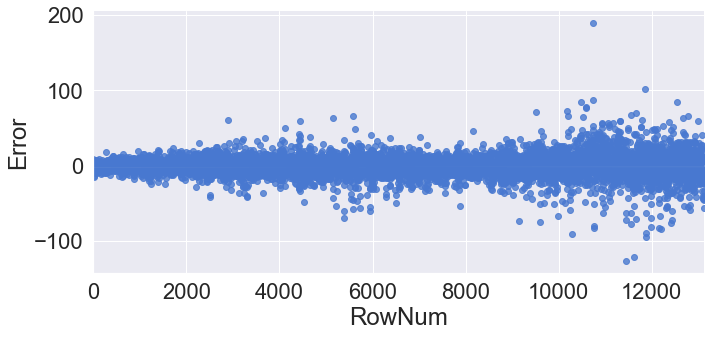

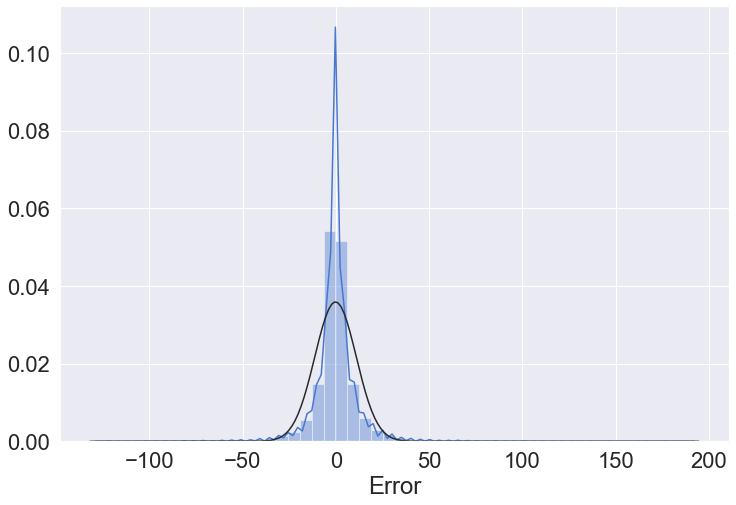

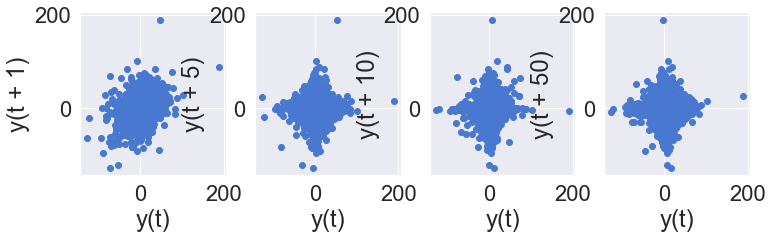

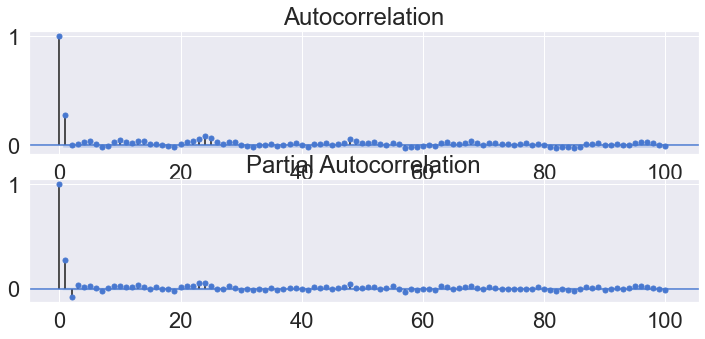

In [6]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# Applying Agile Model
# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.grid()
plt.show()

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg6_feRSM, ['Error'], X_train_feRSM, graph_on=True)

Test Statistics         -6.84
p-value                  0.00
Used Lag                41.00
Used Observations   13,086.00
dtype: float64

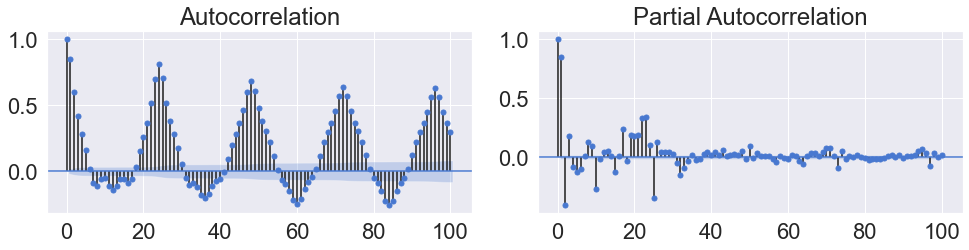

In [7]:
## 정상성 테스트 및 모수추론(p=1, q=1, d=0, P=1, Q=1, D(m)=12)
result = pd.Series(sm.tsa.stattools.adfuller(Y_train_feR.values.flatten())[0:4],
                   index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
display(result)

plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

In [ ]:
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1, trend_diff_order, 1),
                               seasonal_order = (1, seasonal_diff_order, 1, seasonal_order)).fit()
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()

ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
               pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
               pd.DataFrame(pred_te_ts.sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

In [ ]:
logarithm = True
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12

if logarithm:
    Y_train_feR = np.log(Y_train_feR).copy()
    Y_test_feR = np.log(Y_test_feR).copy()
    
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1, trend_diff, 1),
                               seasonal_order=(1, seasonal_diff, 1, seasonal_order)).fit()
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_te_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax_ci = fit_te_sarimax.get_forecast(len(Y_test_feR)).conf_int()

In [ ]:
logarithm = True
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12

if logarithm:
    Y_train_feR = np.log(Y_train_feR).copy()
    Y_test_feR = np.log(Y_test_feR).copy()
    
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1),
                               seasonal_order=(1,seasonal_diff_order,1,seasonal_order)).fit()
pred_fit_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_fit_te_ts_sarimax = fit_ts.sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_fit_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()

if logaritm:
    Y_train_feR = np.exp(Y_train_feR).copy()
    Y_test_feR = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()

In [ ]:
logarithm = False
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12

if logaritm:
    Y_train_feR = np.log(Y_train_feR).copy()
    Y_test_feR = np.log(Y_test_feR).copy()

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,  trend_diff_order, 1),
                               seasonal_order=(1, seasonal_diff_order, 1, seasonal_order)).fit()

display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()

if logarithm:
    Y_train_feR = np.exp(Y_train_feR).copy()
    Y_test_feR = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax).copy()
    
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
               pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index.iloc[:,0],
               pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0))

In [ ]:
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]\

trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order(1,trend_diff_order, 1),
                               seasonal_order(1,seasonal_diff_order,1), exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax_get_forecast(len(Y_test_feR), exog=exog_te).conf_int()

ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
               pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
               pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

In [4]:
list(product(p, d, q))

NameError: name 'product' is not defined

In [3]:
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2],m) for candi in list(product(P, D, Q))]

NameError: name 'product' is not defined

In [ ]:
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi list(product(P,D,Q))]

AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result = sm.tsa.SARIMAX(Y_train_feR, trend='c',
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue

print('The smallest AIC is {} for model SARIMAXP{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0],
                               SARIMAX_order[AIC.index(min(AIC))][1], exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_fetecast(len(Y_test_feR, exog=exog_te)).conf_int()




            

In [3]:
import pmdarima as pm

In [5]:
from pmdarima import model_selection

In [ ]:
import pmdaria as pm
from pmdarima import mode_selection

data = pm.datasets.load_wineind()
train, test = modelselection.train_test_split(data, train_size=150)

autoarima = pm.auto_arima(train,
                          stationary=False,
                          with_intercept=True,
#                           start_p=0, d=None, start_q=0,
#                           max_p=5, max_d=1, max_q=5,
                          seasonal=True, m=12,
                          max-order=30, maxiter=5,
#                           start_P=0, D=None, start_Q=0,
#                           max_P=5, max_D=1, max_Q=5,
                          information_criterion='bic',
                          trace=True, suppress_warnings=True)
display(autoarima.summary())
pred_tr_ts_autoarima = autoarima.predict_in_sample()
pred_tr_ts_autoarima = autoarima.predict(n_periods=len(train))
pred_te_ts_autoarima = autoarima.predict(n_periods = len(test),
                                        return_conf_int=True)[0]
pred_te_ts_autoarima_ci = autoarima.predict(n_periods=len(test),
                                           return_conf_int=True)[1]

Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(pd.DataFrame(train), pred_tr_ts_autoarima,
                                                                                  pd.DataFrame(test), pred_te_ts_autoarima, graph_on=True)

display(Score_ts_autoarima)
ax = pd.DataFrame(test).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_autoarima, columns=['prediction'].plot(kind='line',
                                                              linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci).index,
               pd.DataFrame(pred_te_ts_autoarima_ci).iloc[:,0],
               pd.DataFrame(pred_te_ts_autoarima_ci).iloc[:,1], color='k', alpha=0.15)
plt.show()
             
error_analysis(Resid_tr_ts_autoarima, ['Error'], pd.DataFrame(train), graph_on=True)


In [ ]:
import pmdarima as pm

location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

raw_fe = feature_engineering(raw_all)

target = ['count_trend', 'count_seasonal', 'count_Day', 'count_week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)

Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in rew_fe.columns if x not in Y_colname + X_colname]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_tes_feR, target)

X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_tes_feR)

print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()

trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 24

fit_ts_autoarima = pm.auto_arima(Y_train_feR,
                                stationary=False,
                                start_p=0, d=None, start_q=0,
                                max_p=2, max_d=1, max_q=2,
                                seasonal=True, m=24,
                                start_P=0, D=None, start_Q=0,
                                max_P=2, max_D=1, max_Q=2,
                                max_order=30, maxiter=3,
                                stepwise=False,
                                exogenous=X_train_feRSM,
                                infomation_criterion='aic',
                                trace=True, suppress_warnings=True)
display(fit_ts_autoarima.summary())
pred_tr_ts_autoarima = fit_ts_autoarima.predict_in_sample(exogenous=X_train_feRSM)
pred_tr_ts_autoarima = fit_ts_autoarima.predict(n_periods=len(Y_train_feR), exogenous=X_train_feRSM)
pred_te_ts_autoarima = fit_ts_autoarima.predict(n_periods=len(Y_test_feR), exogenous=X_test_feRSM,
                                               return_conf_int=True)[1]

Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(Y_train_feR, pred_tr_ts_autoarima,
                                                                                  Y_test_feR, pred_te_ts_autoarima, graph_on=True)
display(Score_ts_autoarima)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_autoarima,
            index = Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                  xlim=(Y_test_feR.index.min(), Y_test_feR.index.max()),
                                                                  linewidth=3, fontsize=20, ax=ax_
                                                                  )
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).index,
               pd.DataFrame(pred_tes_ts_autoarima_ci, index=Y_test_feR.index.iloc[:,0],
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
               )
plt.show()

error_analysis(Resid_tr_ts_autoarima, ['Error'], Y_train_feR, graph_on=True)